# Импорт библиотек, которые потребуются для анализа данных

In [1]:
import pandas as pd
import os
credit_card = os.path.join('./creditcard.csv')
import seaborn as sns

# models of ML
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier

# preprocessing and metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, roc_auc_score, classification_report, 
    confusion_matrix, precision_recall_fscore_support)
import warnings
warnings.filterwarnings("ignore")

# Загрузка и разбиение датасета

In [7]:
df=pd.read_csv(credit_card)
df = df[['V17','V12','V14','V10','V11','V16','V18','V9','Class']]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 9 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   V17     284807 non-null  float64
 1   V12     284807 non-null  float64
 2   V14     284807 non-null  float64
 3   V10     284807 non-null  float64
 4   V11     284807 non-null  float64
 5   V16     284807 non-null  float64
 6   V18     284807 non-null  float64
 7   V9      284807 non-null  float64
 8   Class   284807 non-null  int64  
dtypes: float64(8), int64(1)
memory usage: 19.6 MB


* Разобьём выборку на тестовую и тренировочную

In [8]:
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:,:-1], df.iloc[:,-1], test_size=0.2, random_state=42, stratify=df.iloc[:,-1])

In [43]:
df_train = pd.concat([X_train, y_train], axis=1)
df_test = pd.concat([X_test, y_test], axis=1)

In [44]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 227845 entries, 265518 to 17677
Data columns (total 9 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   V17     227845 non-null  float64
 1   V12     227845 non-null  float64
 2   V14     227845 non-null  float64
 3   V10     227845 non-null  float64
 4   V11     227845 non-null  float64
 5   V16     227845 non-null  float64
 6   V18     227845 non-null  float64
 7   V9      227845 non-null  float64
 8   Class   227845 non-null  int64  
dtypes: float64(8), int64(1)
memory usage: 17.4 MB


In [11]:
# df.nunique()

* Так как значение признаков Time и Amount повторяются, они скорее помешают обучению модели, поэтому их следует убрать

In [12]:
Y = pd.DataFrame(df.iloc[:,-1])

In [13]:
X = df.iloc[:,1:-2]

# Оставим только важные признаки

In [14]:
from sklearn.ensemble import ExtraTreesClassifier
selector=ExtraTreesClassifier()
result=selector.fit(df[df.columns],df['Class'])

table=pd.DataFrame(result.feature_importances_,index=df.columns,columns=['Importence'])
table.sort_values(by='Importence',ascending=False)

,Importence
Class,0.789201
V17,0.066200
V14,0.044889
V12,0.028765
V11,0.021553
V10,0.019038
V9,0.013142
V16,0.011203
V18,0.006010


## Избавимся от аномалий и выбросов
* Для этого можно применить несколько разных методов: 
    * при помощи среднего и отклонения
    * с использованием Квантилей(Квартилей/.quantile())
    * ещё можно попробовать использовать критерий Шовене, но это в другой раз

* df.describe() 
* Так как медиана и отклонение сильно отличаются друг от друга, можно сделать вывод, что выборка не симметричная

* Посмотрим на ящики с усами;

In [45]:
df_cut = df_train

In [70]:
df_train.Class.value_counts()

0    150069
1        22
Name: Class, dtype: int64

In [47]:
df_train.boxplot(column=['V17','V12','V14','V10','V11','V16','V18','V9','Class'])

<AxesSubplot: xlabel='V9'>

In [19]:
sns.boxplot(data=df_cut, x='V9') # подставляем под x поочерёдно все столбцы

<AxesSubplot: xlabel='V9'>

* видно что в данных очень много выбросов, значит будем избавляться от них!

* Используя метод квантилей, теряем много (100 тысяч) объектов, что не критично, однако, после этого в датасете остаётся только 26 объектов принадлежащих классу 1 (классу мошеннических операций), что Очень критично


* Попробуем натренировать модели после такой очистки, и посмотреть на результат, а после этого попробовать другой метод избавления от аномалий, и снова обучить модели и проверить результат предсказания 

In [48]:
X = df[['V17','V12','V14','V10','V11','V16','V18','V9']]
X.info(), df_cut['Class'].value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 8 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   V17     284807 non-null  float64
 1   V12     284807 non-null  float64
 2   V14     284807 non-null  float64
 3   V10     284807 non-null  float64
 4   V11     284807 non-null  float64
 5   V16     284807 non-null  float64
 6   V18     284807 non-null  float64
 7   V9      284807 non-null  float64
dtypes: float64(8)
memory usage: 17.4 MB


(None,
 0    227451
 1       394
 Name: Class, dtype: int64)

In [ ]:
# for i in X.columns:
#     left_side = df_cut[i].mean() - 5 * df_cut[i].std()
#     right_side = df_cut[i].mean() + 5 * df_cut[i].std()

#     df_cut = df_cut[(df_cut[i] > left_side) & (df_cut[i] < (right_side))]

# df_cut.info(), df_cut['Class'].value_counts()

In [49]:
df_cut

,V17,V12,V14,V10,V11,V16,V18,V9,Class
265518,-0.765670,0.510277,-0.066555,-0.157403,-0.113729,0.352514,0.141938,1.406819,0
180305,-0.270842,0.325560,0.721068,0.284864,-0.254903,-0.754029,-0.695698,0.045826,0
42664,-0.724616,1.820161,0.122746,-2.009561,-0.386845,1.123344,0.147255,0.000772,0
198723,0.072781,-0.722450,-0.195288,1.756121,0.093136,-0.065888,0.768237,-1.118447,0
82325,-0.399525,-0.054708,0.134659,-0.558955,-0.251076,-2.096099,1.597589,-0.044782,0
...,...,...,...,...,...,...,...,...,...
233802,-0.906442,0.584204,0.062302,0.212619,0.319897,0.684356,0.739436,0.995898,0
85418,1.241541,0.373473,-0.401809,0.108640,0.521818,-1.879937,-2.623211,0.452745,0
29062,0.404795,0.445453,0.166727,-0.131553,-0.305690,-0.796913,-1.033061,0.319684,0
13766,-0.247970,-1.666023,1.799882,-0.268878,1.708922,0.705997,0.483059,1.111187,0


In [50]:
def quantile(df_cut, X):
    for i in X.columns:
        a = df_cut[i].quantile(0.25)
        b = df_cut[i].quantile(0.75)
        df_cut = df_cut[(df_cut[i] > a - 1.5 * (b - a)) & (df_cut[i] < b + 1.5 * (b - a))]
    return df_cut

In [51]:
df_train.shape[0]

227845

In [53]:
# Очистим датасет от выбросов, применяя функцию очистки несколько раз, пока она не уберет все выбросы
l = 3
while l !=0:
    first_value = df_train.shape[0]
    df_train = quantile(df_train, X)
    second_value = df_train.shape[0]
    l = first_value - second_value
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 150091 entries, 265518 to 17677
Data columns (total 9 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   V17     150091 non-null  float64
 1   V12     150091 non-null  float64
 2   V14     150091 non-null  float64
 3   V10     150091 non-null  float64
 4   V11     150091 non-null  float64
 5   V16     150091 non-null  float64
 6   V18     150091 non-null  float64
 7   V9      150091 non-null  float64
 8   Class   150091 non-null  int64  
dtypes: float64(8), int64(1)
memory usage: 11.5 MB


In [40]:
for i in X.columns:
    a = df_cut[i].quantile(0.25)
    b = df_cut[i].quantile(0.75)
    df_cut = df_cut[(df_cut[i] > a - 1.5 * (b - a)) & (df_cut[i] < b + 1.5 * (b - a))]
    
df_cut.info(), df_cut['Class'].value_counts()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 150091 entries, 265518 to 17677
Data columns (total 9 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   V17     150091 non-null  float64
 1   V12     150091 non-null  float64
 2   V14     150091 non-null  float64
 3   V10     150091 non-null  float64
 4   V11     150091 non-null  float64
 5   V16     150091 non-null  float64
 6   V18     150091 non-null  float64
 7   V9      150091 non-null  float64
 8   Class   150091 non-null  int64  
dtypes: float64(8), int64(1)
memory usage: 11.5 MB


(None,
 0    150069
 1        22
 Name: Class, dtype: int64)

In [112]:
df_cut

,V17,V12,V14,V10,V11,V16,V18,V9,Class
265518,-0.765670,0.510277,-0.066555,-0.157403,-0.113729,0.352514,0.141938,1.406819,0
180305,-0.270842,0.325560,0.721068,0.284864,-0.254903,-0.754029,-0.695698,0.045826,0
270403,-1.097096,1.158784,0.032692,-0.499631,0.101414,0.615232,1.078787,1.485832,0
235709,-0.494964,0.499746,-0.201325,-0.166011,-0.975933,0.068961,0.190176,1.465829,0
263511,-0.714205,0.678564,0.887553,0.110757,0.752840,0.056597,-0.008122,0.322583,0
...,...,...,...,...,...,...,...,...,...
176250,0.277227,1.073161,0.467687,-0.240386,0.741316,-0.960874,-1.207569,0.917156,0
3441,-0.783303,1.319156,0.161817,-0.999876,1.648799,-0.474020,0.392973,0.463473,0
233802,-0.906442,0.584204,0.062302,0.212619,0.319897,0.684356,0.739436,0.995898,0
29062,0.404795,0.445453,0.166727,-0.131553,-0.305690,-0.796913,-1.033061,0.319684,0


In [ ]:
df_class_zero = df[df['Class'] == 0]
df_class_zero['Class'].value_counts()

0    284315
Name: Class, dtype: int64

In [ ]:
df_trash_bin = df_cut[df_cut['Class'] == 0].iloc[:492,:]
df_trash_bin['Class'].value_counts()

0    492
Name: Class, dtype: int64

In [79]:
df_fraud = df[df['Class'] == 1].iloc[:200,:]
df_fraud['Class'].value_counts()

1    200
Name: Class, dtype: int64

In [80]:

df_new_try = pd.concat([df_trash_bin, df_fraud], axis=0) 

df_new_try['Class'].value_counts()

0    492
1    200
Name: Class, dtype: int64

In [81]:
df_class = pd.concat([df_class_zero, df[df['Class'] == 1].iloc[201:,:]], axis=0)
df_class['Class'].value_counts()

0    284315
1       291
Name: Class, dtype: int64

In [82]:
df_cut['Class'].value_counts()

0    228162
1        38
Name: Class, dtype: int64

* После избавления от аномалий, в нашем датасете стало на 100 тысяч объектов меньше

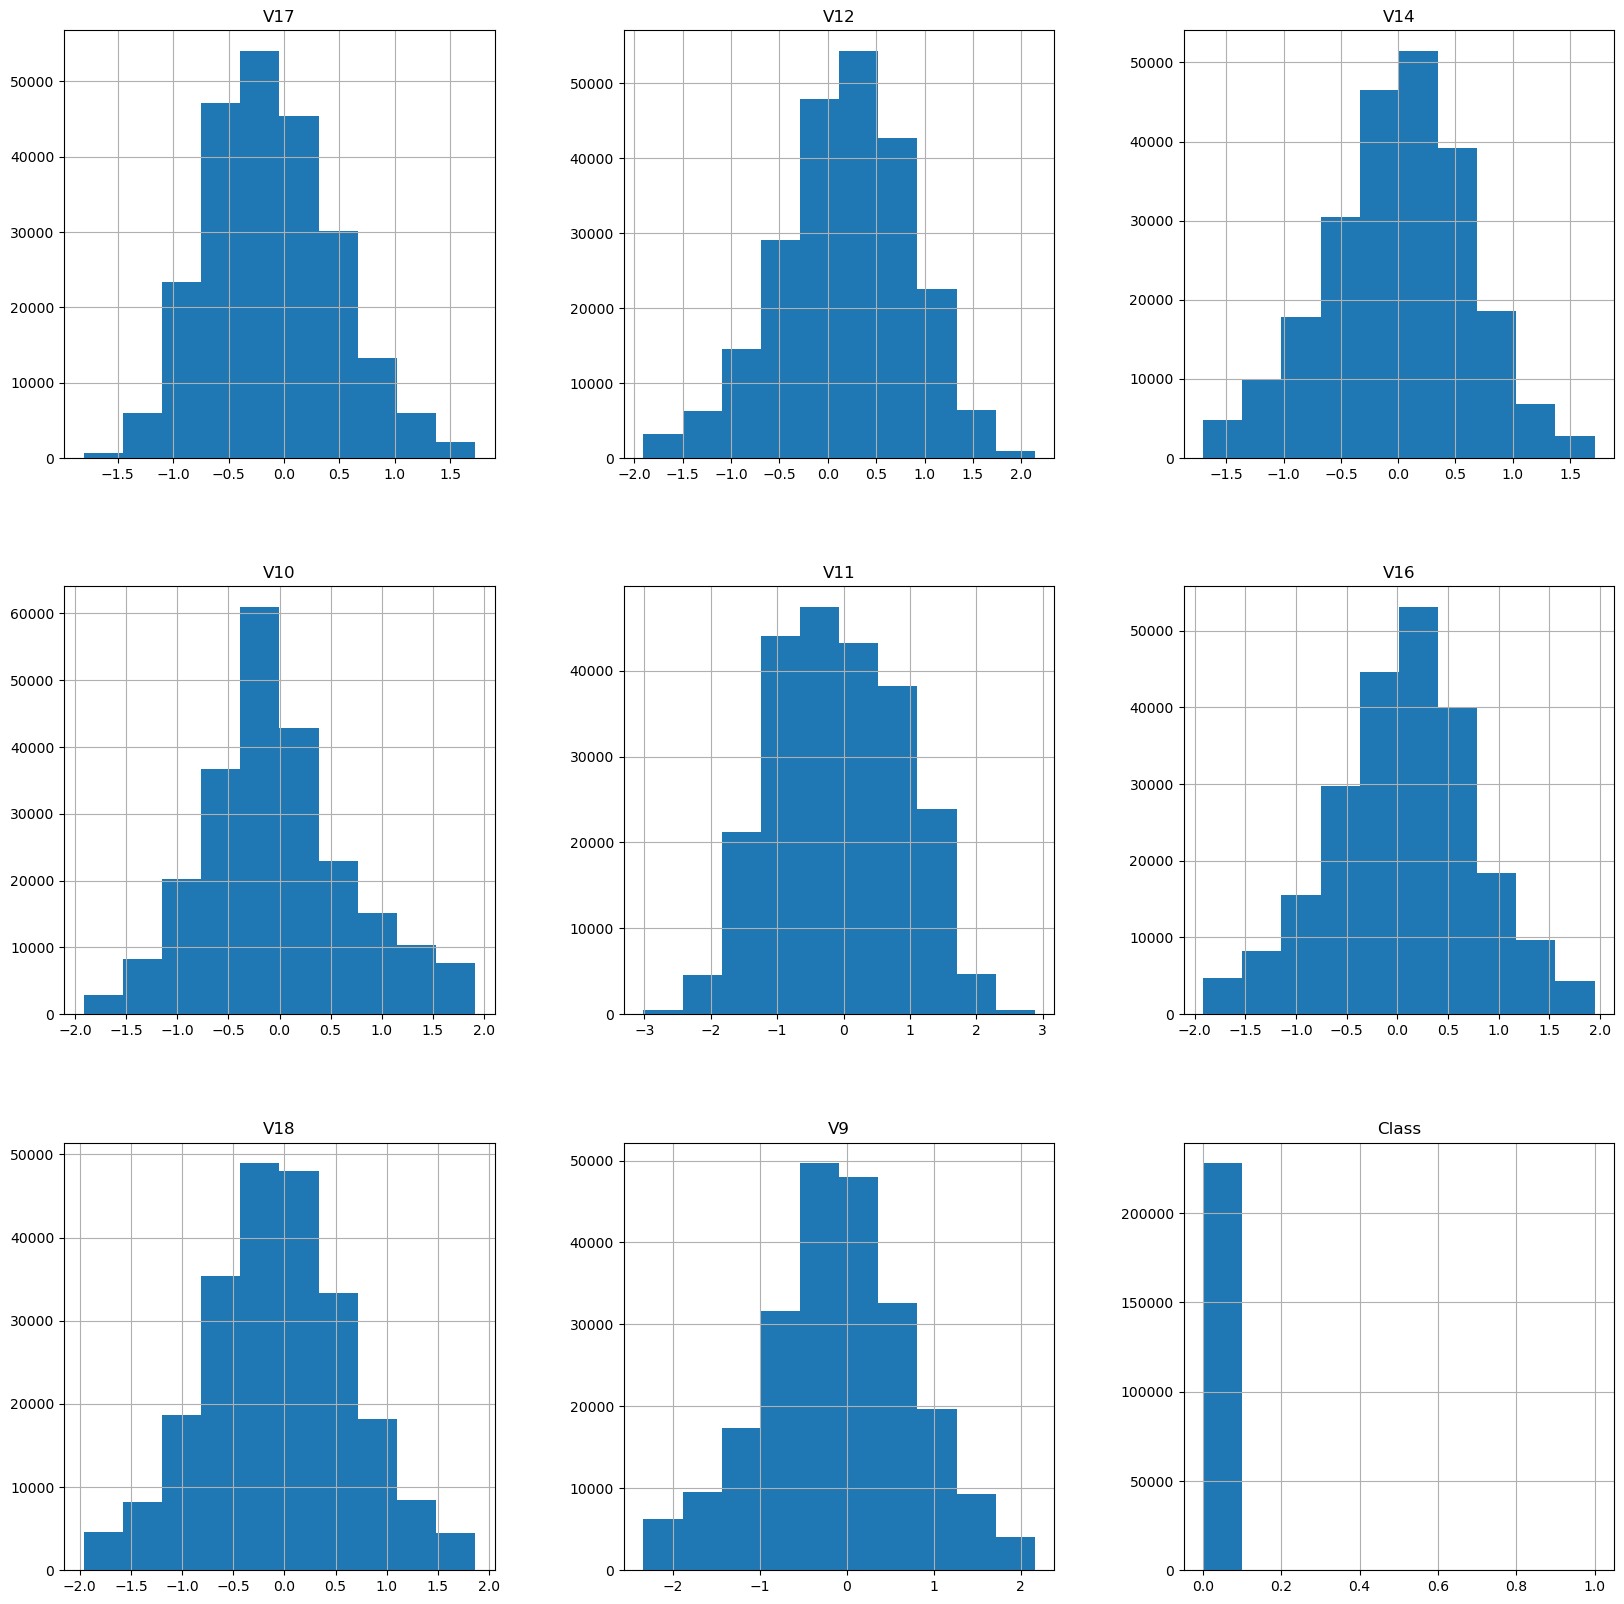

In [83]:
df_cut.hist(figsize = (20, 20));

<AxesSubplot: >

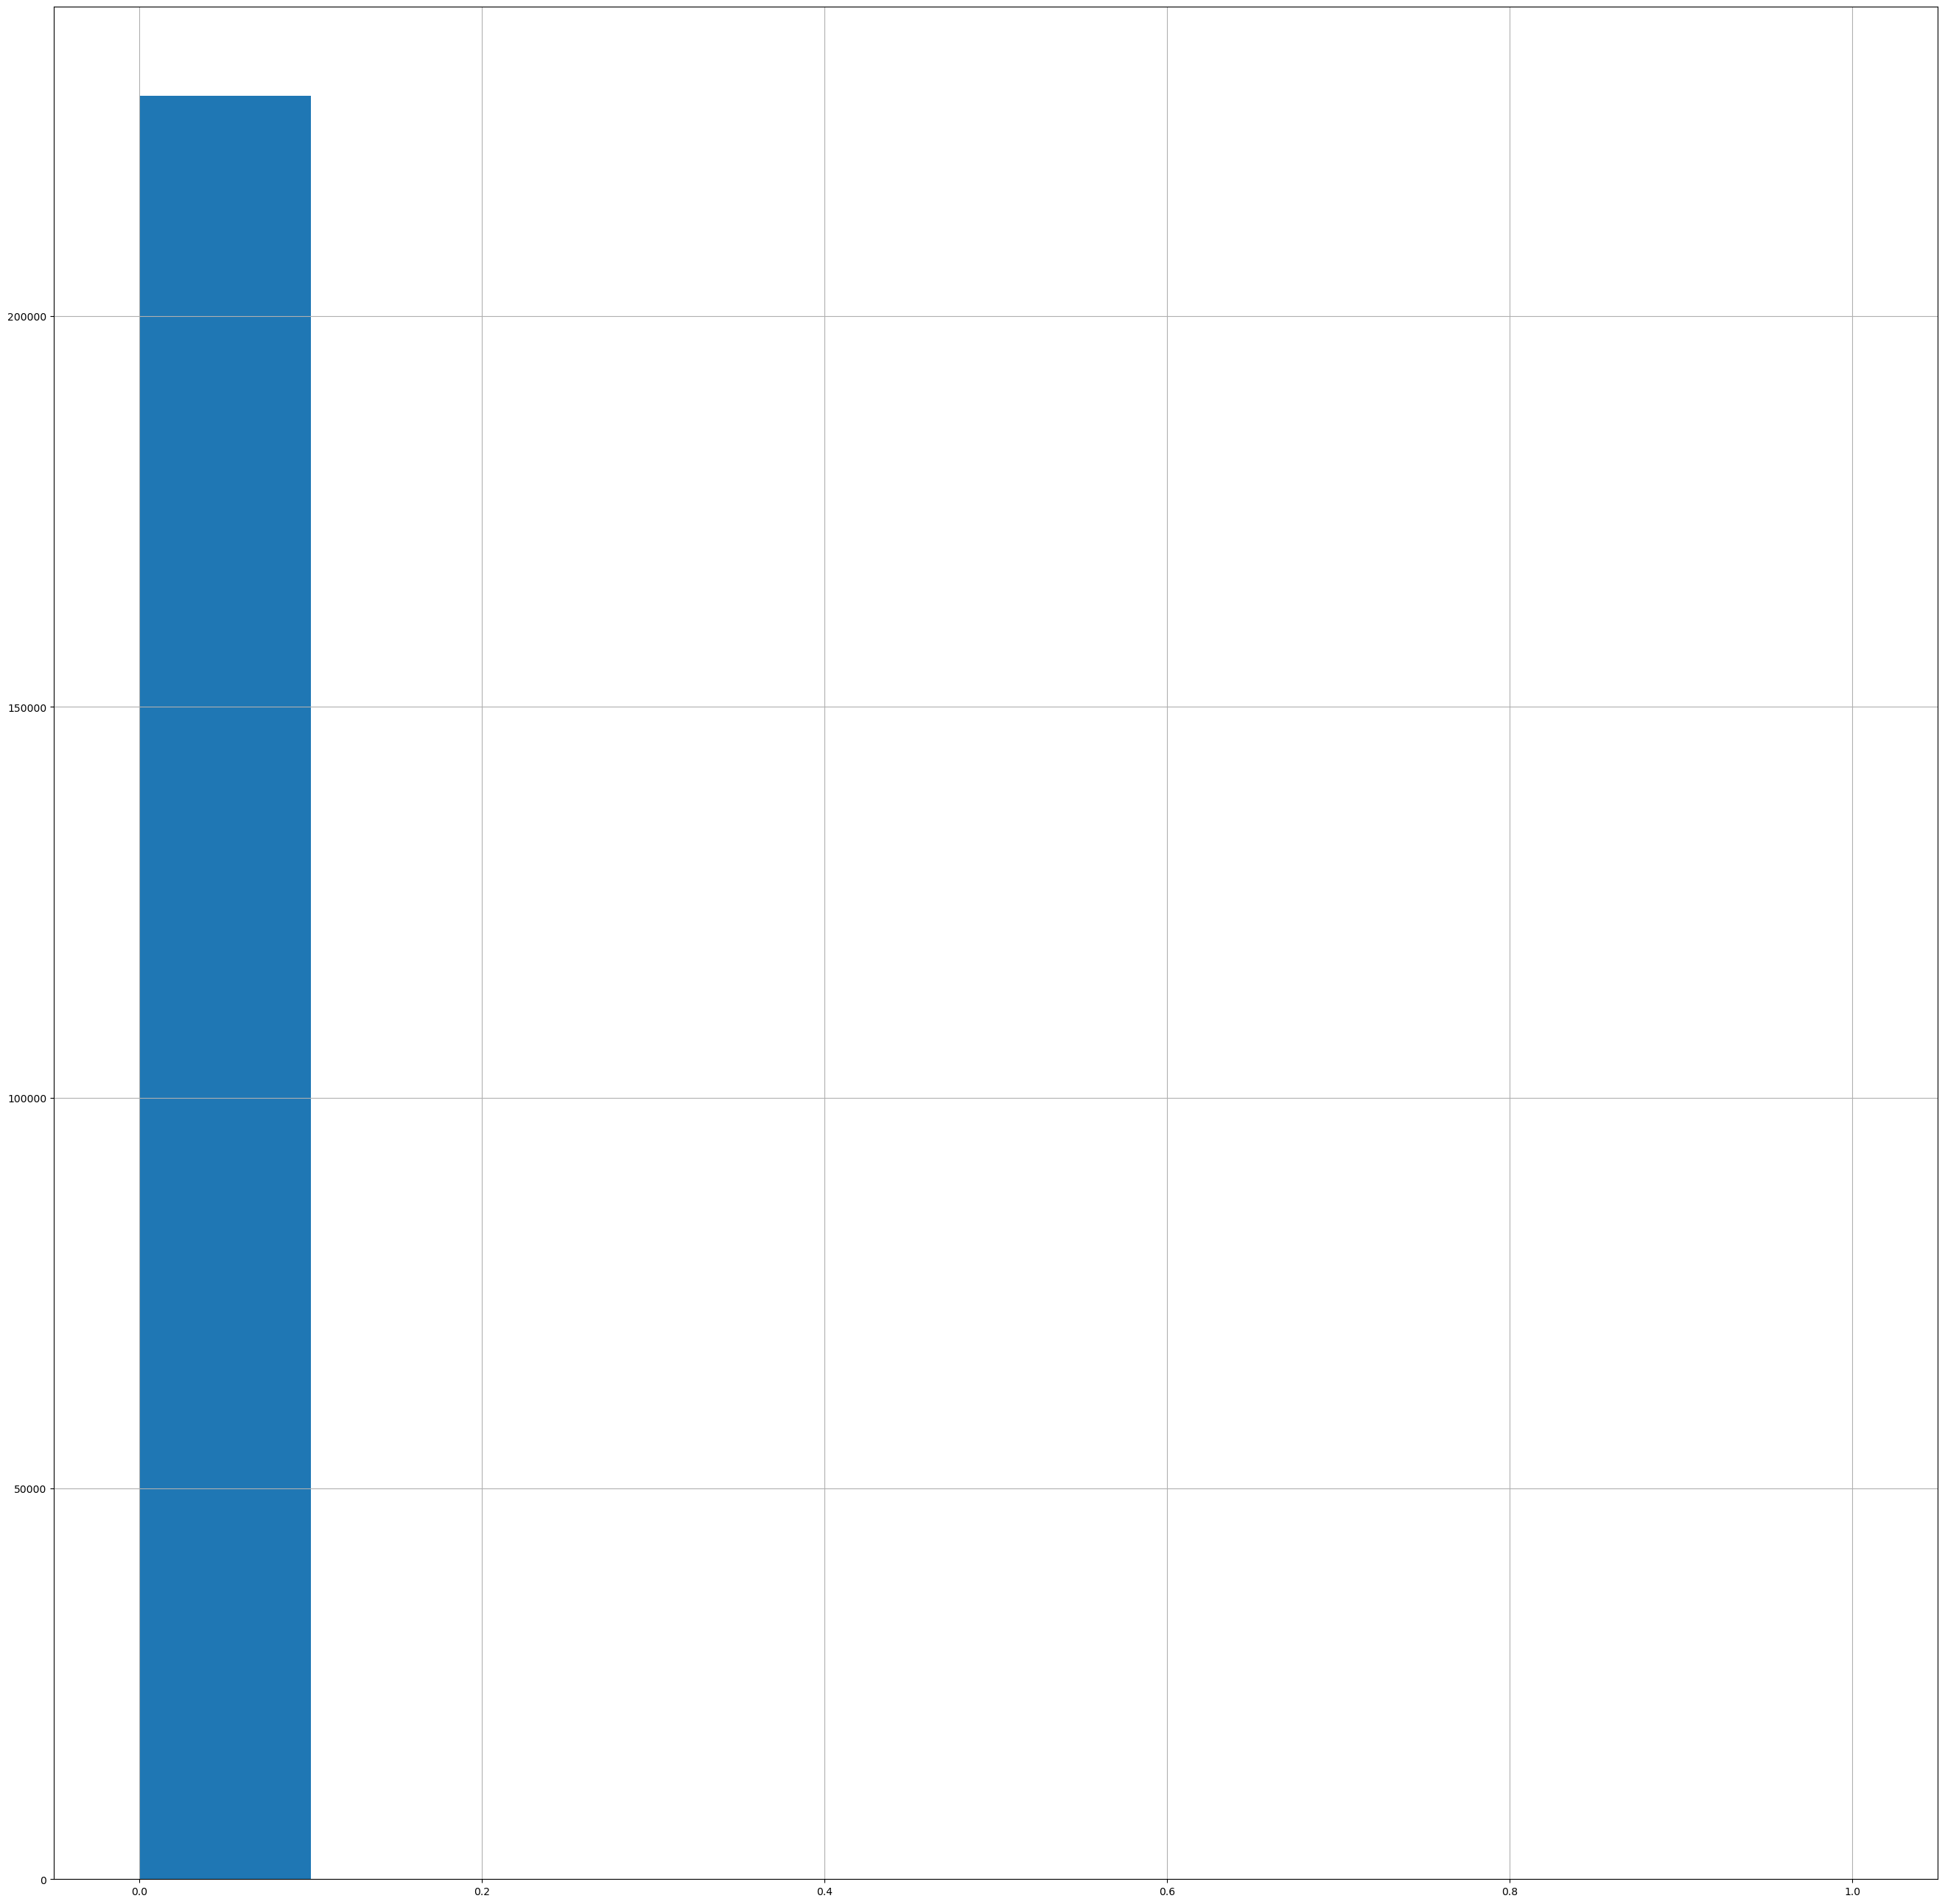

In [84]:
df_cut['Class'].hist(figsize=(33,33))

* Присутствует явный дисбалланс классов

# Разбиение на тренировочную и тестовую выборку

In [58]:
X_train

,V17,V12,V14,V10,V11,V16,V18,V9
265518,-0.765670,0.510277,-0.066555,-0.157403,-0.113729,0.352514,0.141938,1.406819
180305,-0.270842,0.325560,0.721068,0.284864,-0.254903,-0.754029,-0.695698,0.045826
42664,-0.724616,1.820161,0.122746,-2.009561,-0.386845,1.123344,0.147255,0.000772
198723,0.072781,-0.722450,-0.195288,1.756121,0.093136,-0.065888,0.768237,-1.118447
82325,-0.399525,-0.054708,0.134659,-0.558955,-0.251076,-2.096099,1.597589,-0.044782
...,...,...,...,...,...,...,...,...
233802,-0.906442,0.584204,0.062302,0.212619,0.319897,0.684356,0.739436,0.995898
85418,1.241541,0.373473,-0.401809,0.108640,0.521818,-1.879937,-2.623211,0.452745
29062,0.404795,0.445453,0.166727,-0.131553,-0.305690,-0.796913,-1.033061,0.319684
13766,-0.247970,-1.666023,1.799882,-0.268878,1.708922,0.705997,0.483059,1.111187


In [69]:

df_train[df_train.Class == 1]

,V17,V12,V14,V10,V11,V16,V18,V9,Class
74794,0.536817,-0.814310,-0.831483,-0.049233,-0.153131,1.188907,-0.051403,0.887673,1
95534,-0.397246,1.375941,-0.819319,-0.371672,-0.245677,0.125853,0.272377,1.169425,1
124036,0.223887,-0.417898,-1.074999,-1.025335,1.500629,1.377769,1.311073,-0.133341,1
131272,0.306339,0.933216,0.521484,0.269562,1.293418,0.059869,0.265052,-1.242265,1
58761,0.705794,-0.818804,-0.994581,-0.552903,-0.668359,0.624003,0.524182,0.128119,1
108258,0.120608,-0.868686,1.027584,0.324239,-1.273935,0.256216,-0.052346,-1.232089,1
214775,-0.223768,-0.075707,1.065262,0.217630,0.253931,-0.911031,0.768370,0.756307,1
68633,-0.868183,0.687488,-0.007791,-0.045088,-0.876738,0.377154,-0.067135,-0.079512,1
254395,-0.828193,-0.973764,0.141332,1.081514,-1.514205,0.418268,-0.302239,-1.555142,1
55401,0.874891,-0.105359,-0.819902,-0.550545,1.480286,0.201151,0.941477,-0.765054,1


In [66]:
X_train = df_train.iloc[:,:-1]
y_train = df_train.iloc[:,-1]

In [175]:

random_state = 42

X_train, X_test, y_train, y_test = train_test_split(
    df.iloc[:,:-1], df.iloc[:,-1], 
    stratify=df.iloc[:,-1], random_state=random_state, 
    test_size=0.33)

y_train.value_counts()

0    190490
1       330
Name: Class, dtype: int64

In [174]:

random_state = 42

X_train, X_test, y_train, y_test = train_test_split(
    df_new_try.iloc[:,:-1], df_new_try.iloc[:,-1], 
    stratify=df_new_try.iloc[:,-1], random_state=random_state, 
    test_size=0.33)

y_train.value_counts()

0    329
1    134
Name: Class, dtype: int64

In [88]:
X_train, X_test, y_train, y_test = df_new_try.iloc[:,:-1], df_class.iloc[:,:-1], df_new_try.iloc[:,-1], df_class.iloc[:,-1]
X_train

,V17,V12,V14,V10,V11,V16,V18,V9
0,0.207971,-0.617801,-0.311169,0.090794,-0.551600,-0.470401,0.025791,0.363787
1,-0.114805,1.065235,-0.143772,-0.166974,1.612727,0.463917,-0.183361,-0.255425
4,-0.237033,0.538196,-1.119670,0.753074,-0.822843,-0.451449,-0.038195,0.817739
5,-0.058133,0.359894,-0.137134,-0.371407,1.341262,0.401726,0.068653,-0.568671
6,0.002821,-0.153826,0.167372,-0.099254,-1.416907,-0.443587,-0.611987,0.464960
...,...,...,...,...,...,...,...,...
79883,-4.826246,-3.570394,-3.988415,-3.393553,3.128440,-2.843785,-0.703883,-2.329629
80760,-6.131887,-4.226225,-4.710498,-4.170623,3.762306,-4.739084,-2.425871,-1.362198
81186,-9.874560,-6.848978,-7.460103,-3.288204,2.886091,-4.334783,-3.541903,-1.977593
81609,-4.460495,-2.718731,-5.586873,-4.350685,3.064246,-2.502049,-0.870526,-0.802005


In [60]:
def pipeline(model, weight=None):
    if weight is not None:
        model.fit(X_train, y_train, sample_weight=weight)
    else:
        model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    # Summary of the predictions made by the classifier
    print(classification_report(y_test, y_pred))
    return roc_auc_score(y_test, y_pred)

In [194]:
from sklearn.utils import class_weight
import numpy as np
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)


In [201]:
y_train.value_counts()

0    190490
1       330
Name: Class, dtype: int64

In [64]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(max_depth=5, random_state=42)
pipeline(clf)
#fit the model using class weights
clf.fit(X_train, y_train)#, sample_weight=class_weights)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.00      0.00      0.00        98

    accuracy                           1.00     56962
   macro avg       0.50      0.50      0.50     56962
weighted avg       1.00      1.00      1.00     56962

Class      0   1
row_0           
0      56856  98
1          8   0
[[56856     8]
 [   98     0]]


DecisionTreeClassifier(max_depth=5, random_state=42)

In [189]:
from sklearn.ensemble import GradientBoostingClassifier
clf = GradientBoostingClassifier(n_estimators=10, learning_rate=1.0,
    max_depth=1, random_state=0)
pipeline(clf)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     93825
           1       0.71      0.67      0.69       162

    accuracy                           1.00     93987
   macro avg       0.85      0.83      0.84     93987
weighted avg       1.00      1.00      1.00     93987

Class      0    1
row_0            
0      93780   54
1         45  108
[[93780    45]
 [   54   108]]


0.833093525179856

# Попробую нейронку


In [61]:
kNN = KNeighborsClassifier(n_neighbors=5,n_jobs=4)
pipeline(kNN)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.00      0.00      0.00        98

    accuracy                           1.00     56962
   macro avg       0.50      0.50      0.50     56962
weighted avg       1.00      1.00      1.00     56962

Class      0   1
row_0           
0      56864  98
[[56864     0]
 [   98     0]]


0.5

In [96]:
RF=RandomForestClassifier(n_estimators=25, random_state=3)
pipeline(RF)

              precision    recall  f1-score   support

           0       1.00      0.91      0.95    284315
           1       0.01      0.90      0.02       291

    accuracy                           0.91    284606
   macro avg       0.50      0.90      0.49    284606
weighted avg       1.00      0.91      0.95    284606

Class       0    1
row_0             
0      258421   30
1       25894  261
[[258421  25894]
 [    30    261]]


0.9029160882432019

In [111]:
from sklearn import tree
treee = tree.DecisionTreeClassifier(max_depth=4)
pipeline(treee)


              precision    recall  f1-score   support

           0       1.00      0.90      0.95    284315
           1       0.01      0.91      0.02       291

    accuracy                           0.90    284606
   macro avg       0.50      0.91      0.48    284606
weighted avg       1.00      0.90      0.95    284606

Class       0    1
row_0             
0      257261   27
1       27054  264
[[257261  27054]
 [    27    264]]


0.9060307365632463

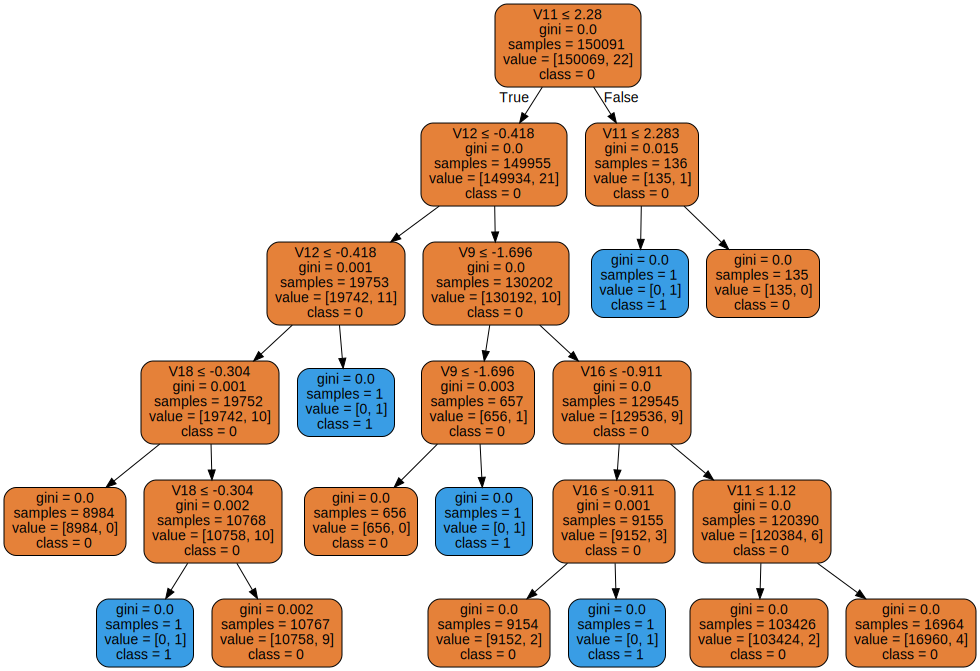

In [71]:
import graphviz
dot_data = tree.export_graphviz(clf, out_file=None,
                                feature_names=X.columns,
                                class_names=['0','1'], 
                                filled=True, rounded=True,special_characters=True)  
graph = graphviz.Source(dot_data)  
graph 